In [17]:
sleep_start = 0  # Bedtime start hour in the simulation
wake_start = 8 # Wakefulness starting time in hours
dt = 20/60 # Time step in hours for numerical integration => 20mins


Simulation_Time = 24  # Total simulation time in hours (including a complete wake-sleep cycle)sleep_start = 0  # Bedtime start hour in the simulation


In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants and Parameters
pi = math.pi  # Mathematical constant for pi (3.14159...)
alpha_0 = 0.16  # Initial activation rate for photic input pathway (per minute)
beta = 0.013  # Decay rate constant of photic input pathway (per minute)
p = 0.6  # Power used for light intensity in activation rate formula

#BASE_CR
I_wake = 150  # Light intensity during wakefulness (lux)
I_sleep = 0  # Light intensity during sleep (lux)
G = 19.875  # Gain factor affecting light input to circadian pacemaker
mu = 0.13  # Coupling constant of nonlinear effects on the circadian oscillator state
q = 1/3  # Factor for regulating influence of B(t) on x_c dynamics
k = 0.55  # Parameter affecting the dynamics of the circadian pacemaker component
tau_x = 24.2  # Period of the circadian oscillator (in hours)
omega_squared = (24 / (tau_x * 0.99729))**2


if ( (wake_start-sleep_start) >=8.0):
    t_w = 0  # Length of prior wakefulness (in hours)
else:
    t_w = 8.0 - (wake_start-sleep_start) 



# Time array for simulation (every 6mins)
time = np.arange(sleep_start,  sleep_start+ Simulation_Time + dt, dt)


# Arrays to store simulation results for each parameter
n_values = []  # Activation rate of photic input pathway over time
x_values = []  # Circadian oscillator state x over time
x_c_values = []  # Circadian pacemaker component x_c over time
H_values = []  # Homeostatic sleep drive H over time
C_values = []  # Circadian component C over time

W_values = []  # Sleep inertia component W over time
H_values_CT = []  # Homeostatic sleep drive for cognitive throughput over time
W_values_CT = []  # Wake inertia for cognitive throughput over time
C_values_CT = []  # Circadian component C over time

A_values = []  # Subjective alertness A over time
T_values = []  # Cognitive throughput T over time


isawake = 0

# Dictionaries to store peaks and troughs information
peaks_dict = {
    'peak1_value': None,
    'time1': None,
    'peak2_value': None,
    'time2': None,
    'difference_from_x_min': None
}

trough_dict = {
    'trough_value': None,
    'time': None,
    'x_min': None,
    'x_min_time': None
}


In [19]:

# Subjective Alertness Constants
r_Hw = 6.64 * 10**(-3)  # Decay rate of homeostatic component during wakefulness (per hour)
u_C = 0.21  # Upper asymptote for the circadian amplitude of subjective alertness
a = 3.59 * 10**(-6)  # Scaling parameter for amplitude decay of circadian component
h_Ac = 0.087  # Scale parameter affecting circadian component response
r_Hsl = 1 / 2.3  # Rate of recovery of homeostatic component during sleep (per hour)
u_H = 0.955  # Upper asymptote for homeostatic component recovery
W_o = -0.5346  # Initial deficit value for sleep inertia component
r_W = 1 / 0.79  # Rate of dissipation of sleep inertia component during wake (per hour)


In [20]:

# Cognitive Throughput Constants
r_Hw_CT = 1 / 38.0  # Decay rate of homeostatic component during wakefulness for cognitive throughput (per hour)
u_C_CT = 0.1503  # Upper asymptote for the circadian amplitude for cognitive throughput
a_CT = 9.27 * 10**(-6)  # Scaling parameter for cognitive throughput amplitude decay
h_Ac_CT = 0.098  # Scale parameter affecting cognitive throughput circadian response
r_Hsl_CT = 1 / 2.14  # Rate of recovery of homeostatic component during sleep for cognitive throughput (per hour)
u_H_CT = 0.95  # Upper asymptote for cognitive throughput homeostatic component recovery
W_o_CT = -0.2868  # Initial deficit value for sleep inertia during cognitive throughput
r_W_CT = 1 / 0.86  # Rate of dissipation of sleep inertia during cognitive throughput (per hour)
t_o = 18.24  # Constant representing delay for homeostatic decay adjustment during wakefulness

In [21]:
# Initial Conditions
x = -0.17  # Initial state of circadian oscillator component x
x_c = -1.22  # Initial state of circadian pacemaker component x_c
n = 0.50  # Initial value of photic input pathway activation
H = 0.0  # Initial value of homeostatic sleep drive component (assumed start)
H_CT= 0.22930454584112198 # Initial value of homeostatic sleep drive for cognitive throughput
W = W_o  # Initial wake inertia value, starting from the sleep deficit value
CBT_min = x + 0.8
CBT_max = 0
x_min = x
time_at_x_min = sleep_start


In [22]:


# Function to calculate activation rate alpha
def calculate_alpha(I):
    if I == 0:
        return 0
    else:
        return alpha_0 * ((I ** p) / (9500 ** p))

# Function to calculate amplitude of circadian component for cognitive throughput
def calculate_A_C(u_C, a, h_Ac, H):
    return u_C - a * math.exp(H / h_Ac)

# Function to calculate circadian component (C) for cognitive throughput
def calculate_C(A_C, x, x_c):
    return A_C * (0.91 * x - 0.29 * x_c)

# Function to calculate homeostatic component (H) during sleep for cognitive throughput
def calculate_H_dot_sleep(r_Hsl, x, u_H, H):
    return r_Hsl  * (u_H - H)

# Function to calculate sleep inertia component (W) during sleep for cognitive throughput
def calculate_W_sleep(H, C, W_o):
    if H + C >= abs(W_o):
        return W_o
    else:
        return -(H + C)

# Function to calculate sleep inertia component (W) during wake for cognitive throughput
def calculate_W_dot_wake(r_W, W):
    return -(r_W) * W

# Function to determine if it is wake or sleep time
def is_awake(t, wake_start, sleep_start):
    t_mod = t % 24
    if wake_start < sleep_start:
        return wake_start <= t_mod < sleep_start
    else:  # Case when sleep period overlaps into the next day
        return t_mod >= wake_start or t_mod < sleep_start



In [23]:

# Part 1: Computation of n(t)
for t in time:
    # Determine light conditions and calculate alpha
    if is_awake(t, wake_start, sleep_start):
        I = I_wake
    else:
        I = I_sleep

    
    alpha = calculate_alpha(I)
    # Calculate n_dot based on sleep or wakefulness
    if not is_awake(t, wake_start, sleep_start):  # During Sleep
        n_dot = -60 * beta * n
        isawake=0
    else:  # During Wakefulness
        n_dot = 60 * (alpha * (1 - n) - beta * n)
        isawake=1
    
    # Update n value
    n = n + n_dot * dt  
    
    if t % 24 == sleep_start:
        x = -0.17
        x_c = -1.22
        n = 0.50
    
    n_values.append(n)
  
    # Calculate N(x)
    N_x = (1 / 3) * x + (4 / 3) * x**3 - (256 / 105) * x**7

    # Part 2: Computation of x(t)
    # Calculate B(t) based on light conditions
    if not is_awake(t, wake_start, sleep_start):  # During Sleep
        B = 0
    else:  # During Wakefulness
        B = G * (1 - n) * alpha * (1 - 0.4 * x) * (1 - 0.4 * x_c)

  
    if x + 0.8 < CBT_min:
        CBT_min = x + 0.8
        x_min = x
        time_at_x_min = t
    
    # Calculate x_dot
    x_dot = (pi / 12) * (x_c + mu * N_x + B)
    
    # Update x value
    x = x + x_dot * dt
    x_values.append(x)

    # Part 3: Computation of x_c(t)
    # Calculate x_c_dot
    x_c_dot = (pi / 12) * (q * B * x_c - x * (omega_squared + k * B))
    
    # Update x_c value
    x_c = x_c + x_c_dot * dt
    x_c_values.append(x_c)
    # Part 4: Computation of H(t)
    if not is_awake(t, wake_start, sleep_start):  # During Sleep
        H_dot = calculate_H_dot_sleep(r_Hsl, x, u_H, H)
        H_dot_CT = calculate_H_dot_sleep(r_Hsl_CT, x, u_H_CT, H_CT)
        if(abs(t_w-1) > 0):
            t_w = abs(t_w-1)
        else:
            t_w=0
    else:  # During Wakefulness
        t_w += 1
        H_dot = -(t**2) / (t + t_o) * r_Hw * (H - u_C)
        H_dot_CT = -2 * t_w * (r_Hw_CT ** 2) * (H_CT - u_C_CT)

    
    # Update H value
    H = H + H_dot * dt
    H_values.append(H)

    H_CT = H_CT + H_dot_CT * dt
    H_values_CT.append(H_CT)
    
  # Part 5: Computation of A(t)
    A_C = calculate_A_C(u_C, a, h_Ac, H)
    A_C_CT = calculate_A_C(u_C_CT, a_CT, h_Ac_CT, H_CT)

    # Calculate C(t)
    C = calculate_C(A_C, x, x_c)
    C_CT = calculate_C(A_C_CT, x, x_c)
    C_values.append(C)
    C_values_CT.append(C_CT)
    
    # Part 6: Computation of W(t)
    if not is_awake(t, wake_start, sleep_start):  # During Sleep
        W = calculate_W_sleep(H, C, W_o)
        W_CT = calculate_W_sleep(H_CT, C_CT, W_o_CT)
    else:  # During Wakefulness
        W_dot = calculate_W_dot_wake(r_W, W)
        W_dot_CT = calculate_W_dot_wake(r_W_CT, W_CT)
        W = W + W_dot * dt
        W_CT = W_CT + W_dot_CT * dt
    
    W_values.append(W)
    W_values_CT.append(W_CT)

  

    # Calculate total subjective alertness A(t)
    A = C + H + W
    A_values.append(A)

    # Calculate total Cognitive Throughput T(t)
    T = C_CT + H_CT + W_CT
    T_values.append(T)
    #print(T_values)
    print("\t At Time: " + str(round(t,2))+ "\t t_w : " + str(round(t_w,2)) + "\t T_value: " + str(round(T,2)))
    """
    if t.is_integer():
        print("Awake") if isawake==1 else print("Sleeping")
        print("\t At Time: " + str(round(t,2))+"\tW: " + str(W)  + " H: \t" + str(H)+ " C: \t" + str(C)+ " \t=> A: \t" + str(A))
        print("\t At Time: " + str(round(t,2))+ "\t W_CT: \t" + str(round(W_CT,2))+  "\t H_CT: \t" + str(round(H_CT,2))+ "\tC_CT: \t" + str(round(C_CT,2))+ " \t => T= \t" + str(round(T,2))+"\n\n")
    """
    # Find peaks for A_values
peaks, _ = find_peaks(T_values)

if len(peaks) >= 2:
    peaks_dict['peak1_value'] = T_values[peaks[0]]
    peaks_dict['time1'] = str(int(time[peaks[0]])) + "'O Clock, " +  str(int((time[peaks[0]] - int(time[peaks[0]]))*60)) + " minutes"
    peaks_dict['peak2_value'] = T_values[peaks[1]]
    peaks_dict['time2'] = str(int(time[peaks[1]])) + "'O Clock, " +  str(int((time[peaks[1]] - int(time[peaks[1]]))*60)) + " minutes"
    peaks_dict['difference_from_x_min'] = abs(time_at_x_min -  time[peaks[1]])

# Find troughs for A_values by inverting the signal
troughs, _ = find_peaks(-np.array(T_values))

if len(troughs) >= 1:
    trough_index = troughs[0]
    trough_dict['trough_value'] = T_values[trough_index]
    trough_dict['time'] = str(int(time[trough_index])) + "'O Clock, " +  str(int((time[trough_index] - int(time[trough_index]))*60)) + " minutes"
    trough_dict['x_min'] = x_min
    trough_dict['x_min_time'] = str(int(time_at_x_min)) + "'O Clock, " +  str(int((time_at_x_min - int(time_at_x_min))*60)) + " minutes"
    
print("Peaks :", str(peaks))
print("Trough :", str(troughs))
# Print peaks and troughs dictionaries
print("Peaks Dictionary:", peaks_dict)
print("Trough Dictionary:", trough_dict)


print(" \n\nCore body temperature follows a circadian pattern, typically reaching its lowest point (CBTmin) approximately 2 to 3 hours before habitual wake-up time.")
print(str(int(time_at_x_min+0.8)) + "'O Clock, " +  str(int((time_at_x_min+0.8 - int(time_at_x_min+0.8))*60)) + " minutes" + "\t Habitual wake-up time: " + str(wake_start))
   

	 At Time: 0.0	 t_w : 1	 T_value: 0.07
	 At Time: 0.33	 t_w : 0	 T_value: 0.15
	 At Time: 0.67	 t_w : 1	 T_value: 0.21
	 At Time: 1.0	 t_w : 0	 T_value: 0.26
	 At Time: 1.33	 t_w : 1	 T_value: 0.31
	 At Time: 1.67	 t_w : 0	 T_value: 0.34
	 At Time: 2.0	 t_w : 1	 T_value: 0.37
	 At Time: 2.33	 t_w : 0	 T_value: 0.4
	 At Time: 2.67	 t_w : 1	 T_value: 0.42
	 At Time: 3.0	 t_w : 0	 T_value: 0.44
	 At Time: 3.33	 t_w : 1	 T_value: 0.46
	 At Time: 3.67	 t_w : 0	 T_value: 0.49
	 At Time: 4.0	 t_w : 1	 T_value: 0.51
	 At Time: 4.33	 t_w : 0	 T_value: 0.53
	 At Time: 4.67	 t_w : 1	 T_value: 0.54
	 At Time: 5.0	 t_w : 0	 T_value: 0.56
	 At Time: 5.33	 t_w : 1	 T_value: 0.57
	 At Time: 5.67	 t_w : 0	 T_value: 0.59
	 At Time: 6.0	 t_w : 1	 T_value: 0.6
	 At Time: 6.33	 t_w : 0	 T_value: 0.61
	 At Time: 6.67	 t_w : 1	 T_value: 0.61
	 At Time: 7.0	 t_w : 0	 T_value: 0.62
	 At Time: 7.33	 t_w : 1	 T_value: 0.63
	 At Time: 7.67	 t_w : 0	 T_value: 0.63
	 At Time: 8.0	 t_w : 1	 T_value: 0.75
	 At Time: 

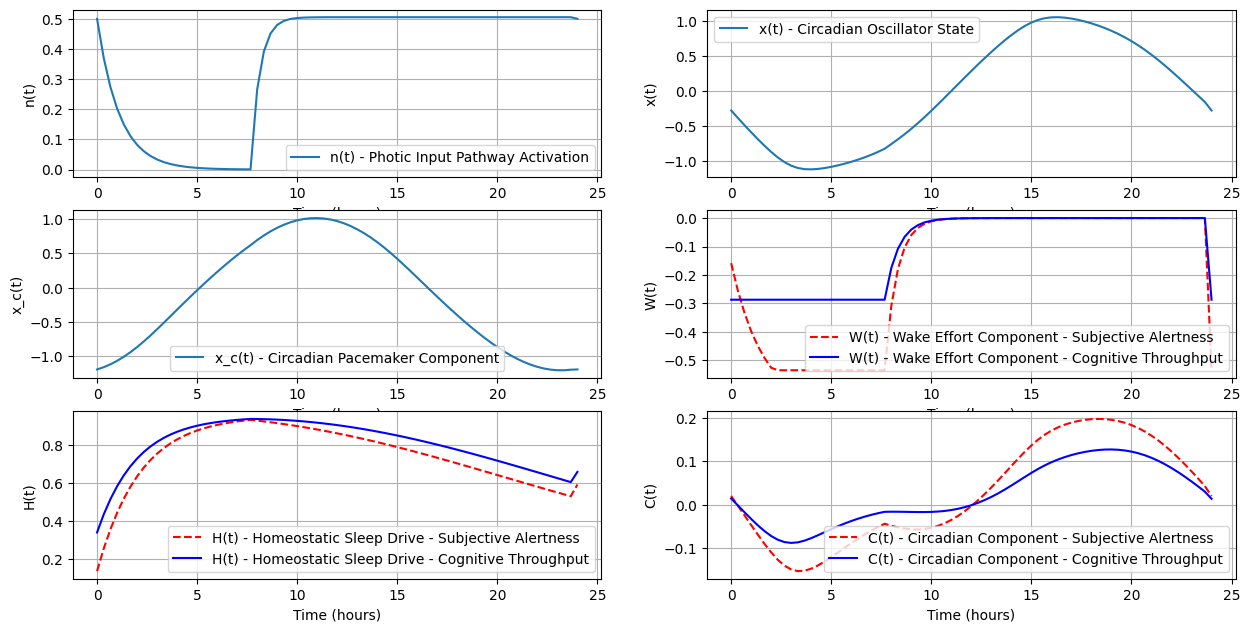

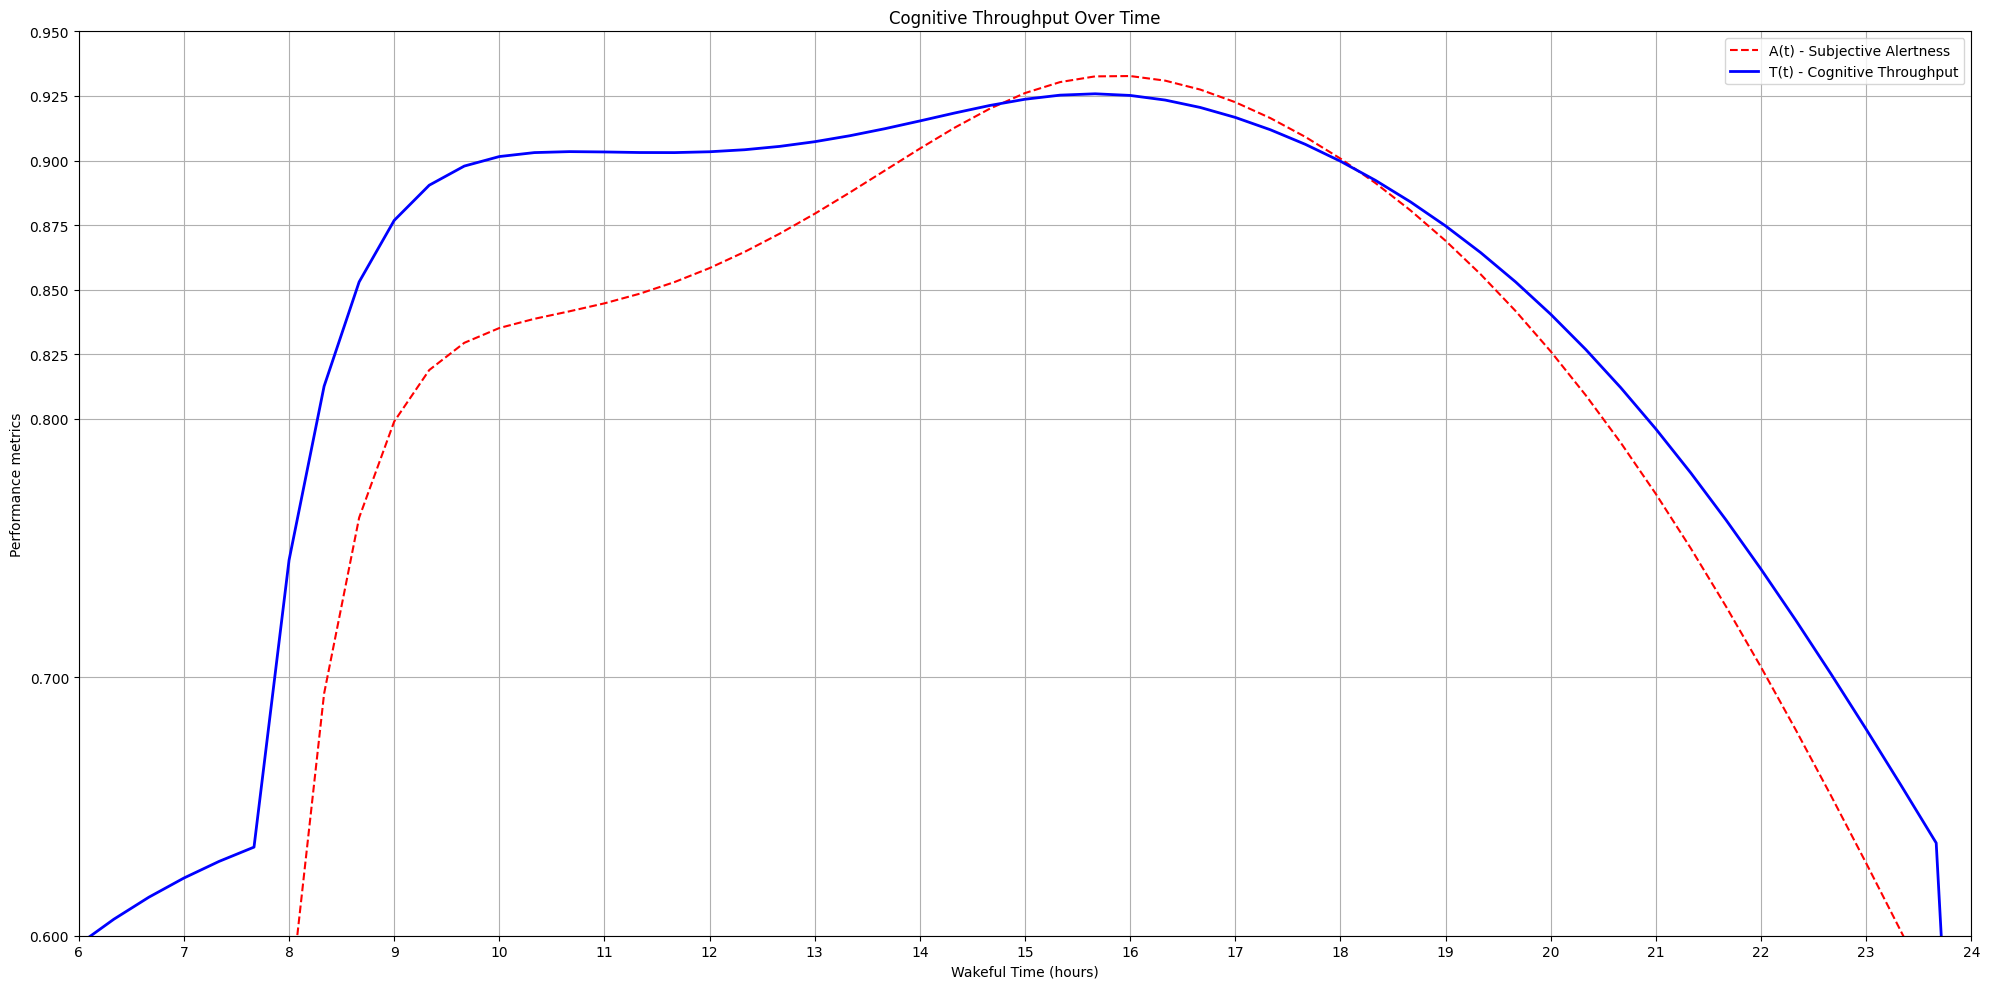

In [25]:


# Plotting results for visualization
plt.figure(figsize=(15, 10))

# Plot n(t)

plt.subplot(4, 2, 1)
plt.plot(time, n_values, label='n(t) - Photic Input Pathway Activation')
plt.xlabel('Time (hours)')
plt.ylabel('n(t)')
plt.legend()
plt.grid(True)

# Plot x(t)
plt.subplot(4, 2, 2)
plt.plot(time, x_values, label='x(t) - Circadian Oscillator State')
plt.xlabel('Time (hours)')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)

# Plot x_c(t)
plt.subplot(4, 2, 3)
plt.plot(time, x_c_values, label='x_c(t) - Circadian Pacemaker Component')
plt.xlabel('Time (hours)')
plt.ylabel('x_c(t)')
plt.legend()
plt.grid(True)

# Plot W(t)
plt.subplot(4, 2, 4)
plt.plot(time, W_values, 'r--', label='W(t) - Wake Effort Component - Subjective Alertness')
plt.plot(time, W_values_CT, 'b-', label='W(t) - Wake Effort Component - Cognitive Throughput')
plt.xlabel('Time (hours)')
plt.ylabel('W(t)')
plt.legend()
plt.grid(True)

# Plot H(t)
plt.subplot(4, 2, 5)
plt.plot(time, H_values, 'r--', label='H(t) - Homeostatic Sleep Drive - Subjective Alertness')
plt.plot(time, H_values_CT, 'b-', label='H(t) - Homeostatic Sleep Drive - Cognitive Throughput')
plt.xlabel('Time (hours)')
plt.ylabel('H(t)')
plt.legend()
plt.grid(True)

# Plot C(t)
plt.subplot(4, 2, 6)
plt.plot(time, C_values, 'r--', label='C(t) - Circadian Component - Subjective Alertness')
plt.plot(time, C_values_CT, 'b-', label='C(t) - Circadian Component - Cognitive Throughput')
plt.xlabel('Time (hours)')
plt.ylabel('C(t)')
plt.legend()
plt.grid(True)


# Plot A(t) and T(t) in the same graph
plt.figure(figsize=(20, 10))
"""
plt.xlim(wake_start,Simulation_Time)
plt.ylim(0.7, 0.95)
plt.xticks(np.arange(wake_start, Simulation_Time + 1, 1) )
plt.yticks([0.7, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95] )
"""
plt.xlim(wake_start,Simulation_Time)
plt.ylim(0.6, 0.95)
plt.xticks(np.arange(wake_start-2, Simulation_Time + 1, 1) )
plt.yticks([0.6, 0.7, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95] )
plt.plot(time, A_values, 'r--', label='A(t) - Subjective Alertness')
plt.plot(time, T_values, 'b-', label='T(t) - Cognitive Throughput', linewidth=2 )
plt.xlabel('Wakeful Time (hours)')
plt.ylabel('Performance metrics')
plt.title('Cognitive Throughput Over Time')
plt.legend()
plt.grid(True)

 
# Show the plot
plt.tight_layout()
plt.show()